In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [2]:
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/MSS_MOSAiC_ArcticOcean_20192020.nc"
mosaic_ds = xr.open_dataset(mosaic_nc)

arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)

In [3]:
# dataset is binned to 1m
# max depth is 439m
max(mosaic_ds["z"].values)

439

In [16]:
737723 - 365.25*2019

283.25

In [5]:
# investigate the time variable, as is the same format as the ArcticMix one
mosaic_ds["stime"].values

array([737723.06924601, 737724.07389639, 737724.08664953, ...,
       738060.3643898 , 738060.39145017, 738060.41079738])

In [21]:
time.stime

<xarray.DataArray 'stime' (nprofile: 1684)>
array([737723.069246, 737724.073896, 737724.08665 , ..., 738060.36439 ,
       738060.39145 , 738060.410797])
Dimensions without coordinates: nprofile
Attributes:
    Unit:     days since 00-Jan-0000 (UTC)

In [22]:
import datetime

time = mosaic_ds
ds_time = time.stime.values

# start counting in first year, but need 0th year instead
reference_date = datetime.datetime(1, 1, 1)
days_since_reference = ds_time.min() - 365.25

reference_date_1 = reference_date + datetime.timedelta(days=days_since_reference)
reference_value_1 = ds_time.min()
reference_date_2 = reference_date_1 + datetime.timedelta(days=ds_time.max()-ds_time.min())
reference_value_2 = ds_time.max()

# Convert the array values to UTC datetimes using linear interpolation
utc_datetimes = np.array([
    reference_date_1 + (value - reference_value_1) * (reference_date_2 - reference_date_1) / (reference_value_2 - reference_value_1)
    for value in ds_time
])

formatted_datetimes = [dt.strftime('%Y-%m-%dT%H:%M:%S.%f') for dt in utc_datetimes]
formatted_array = np.array(formatted_datetimes).reshape(time.stime.shape)
time['time'] = (['nprofile'], formatted_array)

# Data exploration

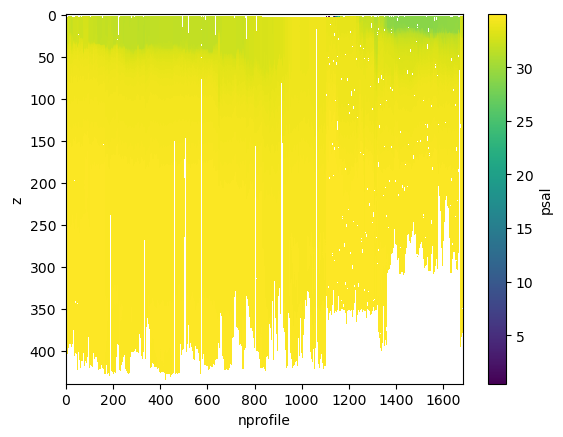

In [24]:
mosaic_ds.psal.plot()
plt.gca().invert_yaxis()

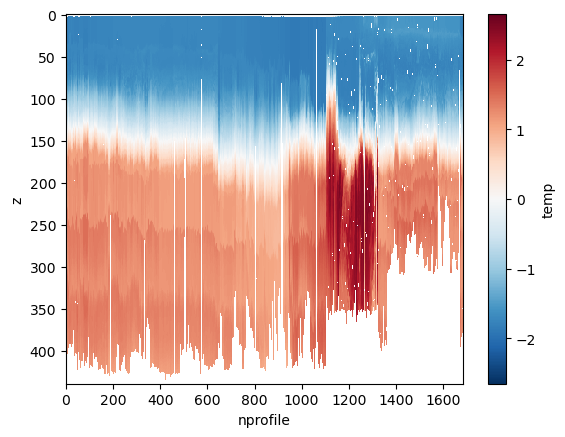

In [6]:
mosaic_ds.temp.plot()
plt.gca().invert_yaxis()

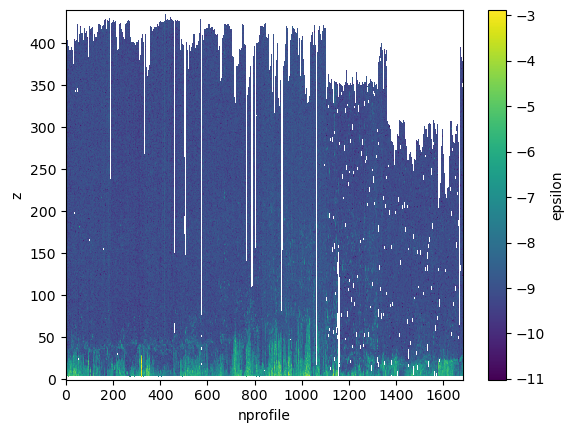

In [11]:
mosaic_ds.epsilon.plot()

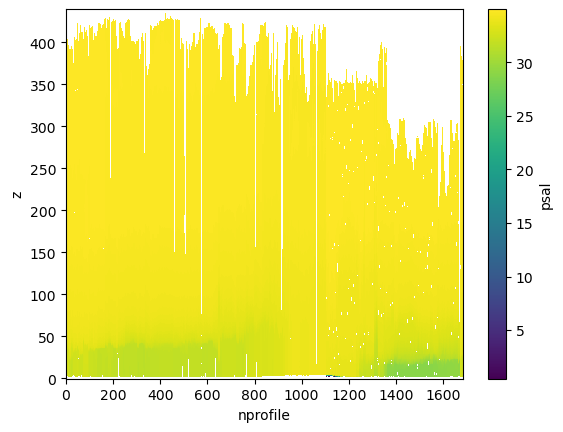

In [37]:
mosaic_ds.psal.plot()

## Investigate three different epsilons in the dataset

In [25]:
# plot the histogram with 20 bins
plt.hist(mosaic_ds.epsilon, bins=20)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of epsilon')

# show the plot
plt.show()

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


KeyboardInterrupt: 

/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/Users/Lisanne/opt/anaconda3/envs/gtc/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


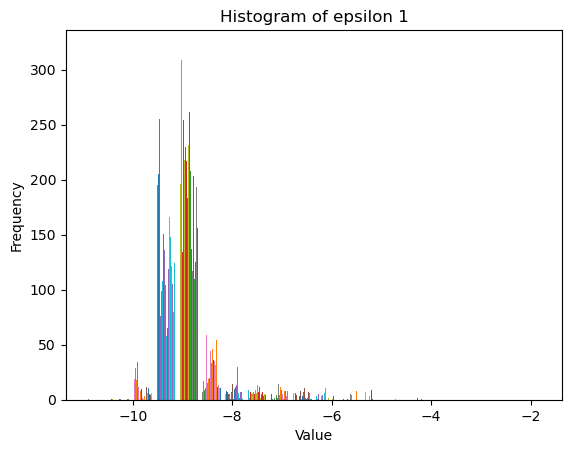

In [38]:
# plot the histogram with 20 bins
plt.hist(mosaic_ds.epsilon1, bins=20)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of epsilon 1')

# show the plot
plt.show()

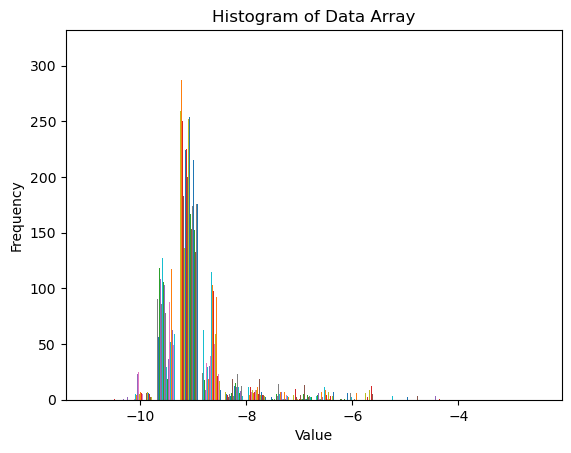

In [57]:
# plot the histogram with 20 bins
plt.hist(mosaic_ds.epsilon2, bins=20)

# add axis labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of epsilon2')

# show the plot
plt.show()

## convert to NC dataset

In [26]:
# rename columns and save to processed data folder
final_ds = time.rename({'temp': 'T', 'psal': 'S', 'slatitude': 'latitude', 'slongitude': 'longitude', 'epsilon': 'eps', 'z': 'depth', 'nprofile': 'profile', 'press': 'P'})

In [30]:
mosaic_ds.to_netcdf('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc')

# locations

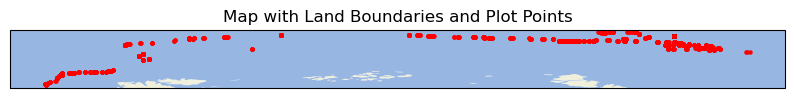

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(mosaic_ds.longitude, mosaic_ds.latitude, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()